# Word Embedding Using Keras

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
# # Google Colab Adhoc Setting
# !nvidia-smi
# nltk.download(['gutenberg','punkt','stopwords'])
# !pip show spacy
# !pip install --upgrade spacy
# #!python -m spacy download en_core_web_trf
# !python -m spacy download en_core_web_lg

Mon Mar  1 00:20:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Sample corpus of text documents

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


## Simple text pre-processing

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

## Load up sample corpus - Bible

In [5]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture

![](../images/text-tokenization-embedding.gif)

![](../images/word2vec-text-to-sequences.gif)

### Build Vocabulary

In [25]:
import keras
from keras.preprocessing import text
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}

# wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
wids = tokenizer.texts_to_sequences(norm_bible)

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


### Build (context_words, target_word) pair generator

In [8]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    # go through each unit in the corpus 
    for words in corpus:
        sentence_length = len(words)
        ## extract context-word pairs
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = keras.utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [9]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


### Build CBOW Deep Network Model

![](../images/word2vec-cbow.gif)

In [10]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            1242500   
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


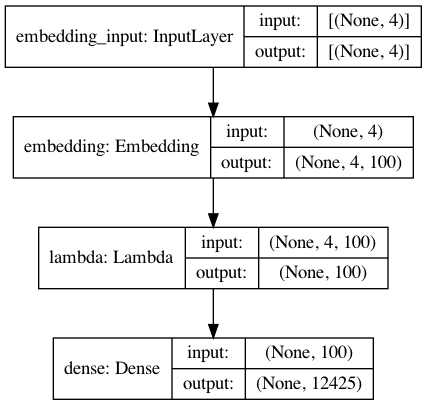

In [15]:
keras.utils.plot_model(cbow, show_shapes=True)

### Train model for 5 epochs

In [16]:
%%time

for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

KeyboardInterrupt: 

### Get word embeddings

In [ ]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,-1.183386,-2.866214,1.046431,0.943265,-1.021784,-0.047069,2.108584,-0.458692,-1.698881,0.905800,...,0.655786,0.703828,0.821803,-0.093732,-2.474536,2.309505,0.713962,-0.175176,0.262700,0.818652
unto,-1.725262,-1.765972,1.411971,0.917713,0.793832,0.310631,1.541964,-0.082523,-1.346811,0.095824,...,1.682762,-0.872293,1.908597,0.977152,-0.835005,1.128618,0.834068,1.852117,-2.522386,-0.053387
lord,1.694633,-0.650949,-0.095796,0.950002,0.813837,1.538206,1.125482,-1.655581,-1.352673,0.409504,...,1.553925,-0.819261,1.086127,-1.545129,-0.035251,1.895598,2.378903,-1.632835,1.375105,0.599096
thou,-1.590623,-0.801968,1.659041,1.314925,-0.455822,1.733872,-0.233771,-0.638922,0.104744,0.490223,...,0.652781,-0.362778,-0.190355,0.040719,-1.988184,2.330042,1.441790,-1.771272,-1.738142,-3.210077
thy,0.386488,-0.834605,0.585985,0.801969,-0.165132,0.999917,1.224088,-0.317555,-0.671106,-1.073181,...,1.267184,-0.564660,0.089618,-0.979835,-0.215604,2.189568,0.529003,-1.682130,-0.632460,0.578122


### Build a distance matrix to view the most similar words (contextually)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'egypt': ['destroy', 'none', 'whole', 'jacob', 'sea'],
 'famine': ['wickedness', 'sore', 'countries', 'cease', 'portion'],
 'god': ['therefore', 'heard', 'may', 'behold', 'heaven'],
 'gospel': ['church', 'fowls', 'churches', 'preached', 'doctrine'],
 'jesus': ['law', 'heard', 'world', 'many', 'dead'],
 'john': ['dream', 'bones', 'held', 'present', 'alive'],
 'moses': ['pharaoh', 'gate', 'jews', 'departed', 'lifted'],
 'noah': ['abram', 'plagues', 'hananiah', 'korah', 'sarah']}

## Implementing a word2vec model using a skip-gram neural network architecture

### Build Vocabulary

In [ ]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('base', 2338), ('feller', 10771), ('sanctuary', 455), ('plunge', 10322), ('azariah', 1120), ('enlightened', 4438), ('horns', 838), ('kareah', 2920), ('nursing', 5943), ('baken', 3492)]


### Build and View sample skip grams ((word1, word2) -> relevancy)

In [ ]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(bible (5766), stank (5220)) -> 0
(james (1154), izri (9970)) -> 0
(king (13), bad (2285)) -> 0
(king (13), james (1154)) -> 1
(king (13), lucius (8272)) -> 0
(james (1154), king (13)) -> 1
(james (1154), bazluth (10091)) -> 0
(james (1154), bible (5766)) -> 1
(king (13), bible (5766)) -> 1
(bible (5766), james (1154)) -> 1


### Build Skip-gram Deep Network Model

In [ ]:
from keras.layers import Dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.models import Model

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model_arch = Dot(axes=1)([word_model.output, context_model.output])
model_arch = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(model_arch)
model = Model([word_model.input,context_model.input], model_arch)
#model.add(Merge([word_model, context_model], mode="dot"))
#model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_12_input (InputLayer)  (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_13_input (InputLayer)  (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_12 (Embedding)         (None, 1, 100)        1242500     embedding_12_input[0][0]         
____________________________________________________________________________________________________
embedding_13 (Embedding)         (None, 1, 100)        1242500     embedding_13_input[0][0]         
___________________________________________________________________________________________

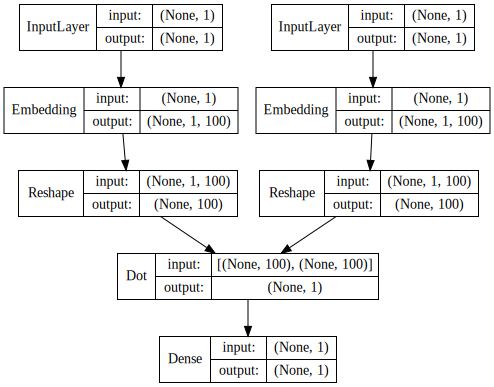

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Train the model for 5 epochs

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 4474.41281086
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3735.81375903
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3759.779281
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 3793.27816557
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 3718.1

### Get word embeddings

In [ ]:
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,0.043252,0.030233,-0.016057,-0.071856,0.005915,0.053170,0.013578,0.000201,0.037018,-0.151811,...,0.289811,0.014798,-0.022350,0.059966,0.107588,-0.006052,-0.112083,0.064291,0.110624,-0.033265
unto,-0.072916,-0.014941,0.018243,-0.206662,-0.018253,0.071634,0.094720,0.008018,-0.003973,-0.076268,...,0.044276,0.097791,-0.120094,0.057171,0.239757,0.063303,0.018524,0.203282,0.093460,-0.110360
lord,-0.024338,0.066582,-0.057416,-0.112375,0.034131,0.103507,-0.000733,0.071466,0.015607,-0.119505,...,0.115495,-0.027881,-0.215636,-0.028494,0.097059,0.050633,-0.234569,0.106756,-0.014540,0.028276
thou,0.084224,0.048217,0.008529,0.025198,0.019296,-0.005508,0.041746,-0.012590,-0.299545,-0.030134,...,0.079110,-0.037630,-0.016609,0.032280,0.055897,0.180336,-0.218525,0.078187,0.077540,-0.039218
thy,0.040458,0.054175,-0.033665,-0.031059,0.053622,0.157648,-0.009812,0.032927,-0.229837,0.002110,...,-0.033932,-0.079629,-0.070454,0.051992,0.029190,-0.023169,-0.259643,-0.016068,0.122141,-0.088576


### Build a distance matrix to view the most similar words (contextually)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'egypt': ['taken', 'pharaoh', 'wilderness', 'gods', 'became'],
 'famine': ['moved', 'awake', 'driven', 'howl', 'snare'],
 'god': ['strength', 'given', 'blessed', 'wherefore', 'lord'],
 'gospel': ['preached', 'must', 'preach', 'desire', 'grace'],
 'jesus': ['disciples', 'christ', 'dead', 'peter', 'jews'],
 'john': ['peter', 'hold', 'mountain', 'ghost', 'preached'],
 'moses': ['commanded', 'third', 'congregation', 'tabernacle', 'tribes'],
 'noah': ['ham', 'terah', 'amon', 'adin', 'zelophehad']}

### Visualize word embeddings

Total words: 48 	Word Embedding shapes: (48, 100)


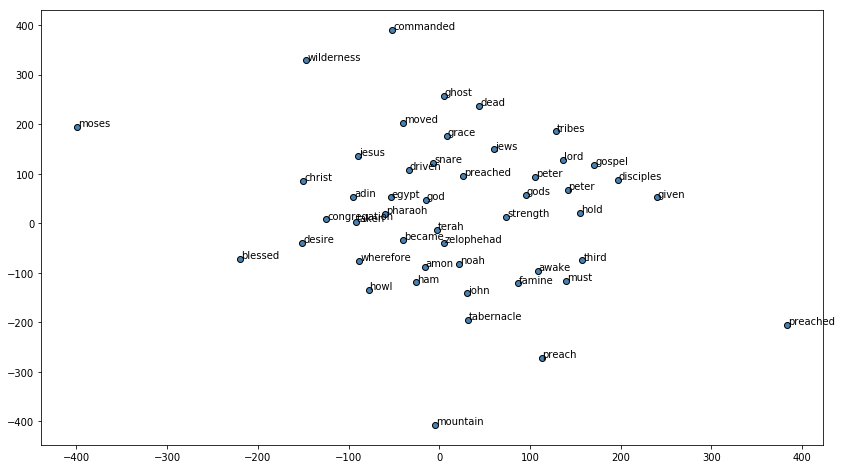

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## References

- Sarkar (2020) Ch 4 Feature Engineering for Text Representation